Autor: Miguel Thomas

In [1]:
import sys
assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from sklearn.model_selection import StratifiedShuffleSplit


## Etapa 1

In [4]:
def load_dataset_url():
  tarbal_path = Path("datasets/housing.tgz")
  if not tarbal_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarbal_path)
    with tarfile.open(tarbal_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
  return pd.read_csv("datasets/housing/housing.csv")

dataset = load_dataset_url()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
dataset['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [8]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
IMAGES_PATH = Path() / "images" / "images_bar_housing"
IMAGES_PATH.mkdir(parents = True, exist_ok = True)

def save_fig(fig_id, tight_layout = True, fig_extention = "jpg", resolution = 300):
    path = IMAGES_PATH / f'{fig_id}.{fig_extention}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extention, dpi=resolution)

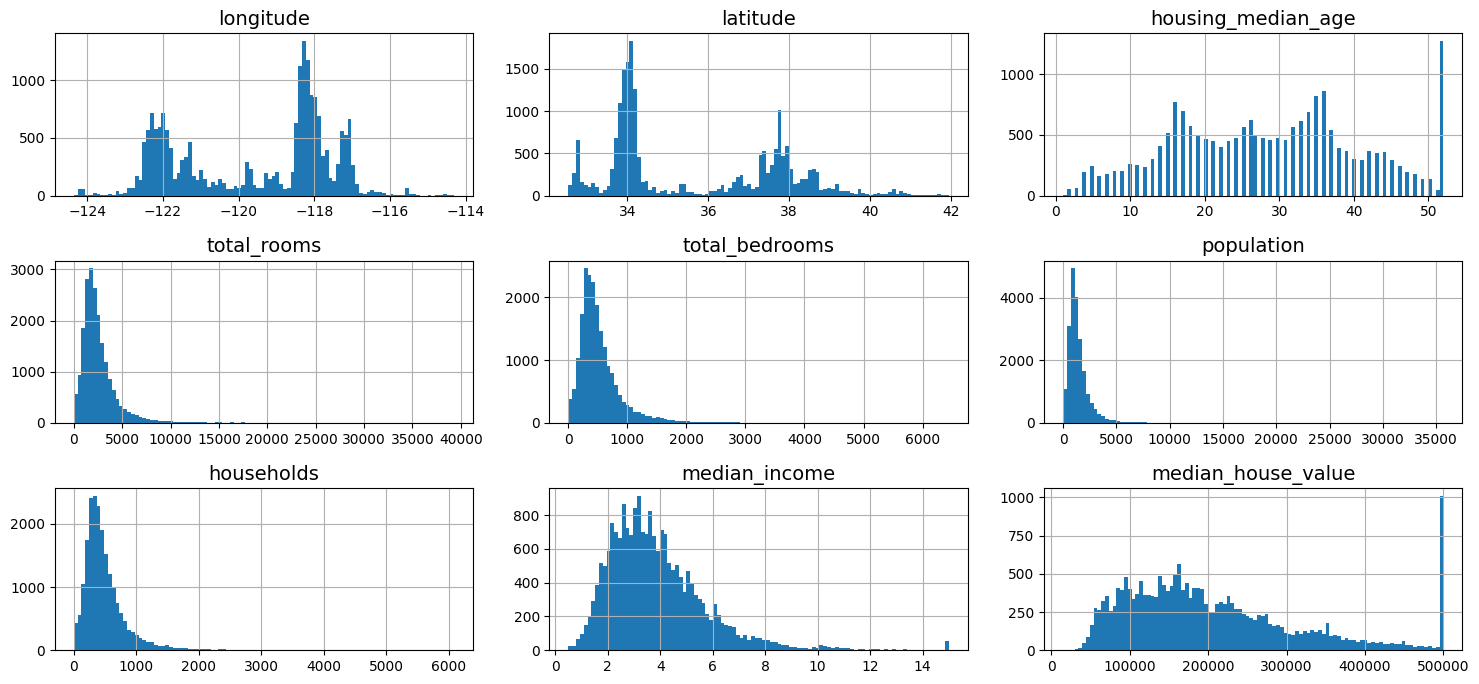

In [10]:
plt.rc('font',size = 12)
plt.rc('axes', labelsize = 12, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

dataset.hist(bins = 100, figsize=(15,7))
save_fig("Grafica atributos Housing(Histograma)")
plt.show()

In [11]:
def shuffle_and_split(data, test_radio):
    shuffle_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_radio)
    test_indices = shuffle_indices[:test_set_size]
    train_indices = shuffle_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]


In [12]:
train, test = shuffle_and_split(dataset, 0.3)

In [13]:
print(len(train))
print(len(test))

14448
6192


In [14]:
np.random.seed(42)

In [15]:
from zlib import crc32

In [16]:
def is_id_in_test(identifier, test_radio):
    return crc32(np.int64(identifier)) < test_radio * 2**32

In [17]:
def  split_data_with_id_hash(data, test_radio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id: is_id_in_test(id, test_radio))
    return dataset.loc[~in_test_set], data.loc[in_test_set]

In [18]:
dataset_witd_id = dataset.reset_index()
train_set, test_set = split_data_with_id_hash(dataset_witd_id, 0.3, "index")

In [19]:
dataset_witd_id["id"] = dataset['longitude']*1000 + dataset['latitude']
train_set, test_set = split_data_with_id_hash(dataset_witd_id, 0.3, "id")

In [20]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY


### Ejercicio

<p>
Muestre los resultados de las celdas 18 y 19 y concluya como se cambiaron los datos de entrenamiento y testeo
</p>

CONCLUSION:

En la Celda 18, el identificador se basa en el índice de fila original del DataFrame. Esto significa que la división es esencialmente aleatoria y no tiene en cuenta las características de los datos.

En la Celda 19, el identificador se basa en una combinación específica de características de los datos (en este caso, la ubicación geográfica). Esto podría llevar a una división que tenga en cuenta la distribución geográfica de los datos, potencialmente asegurando una mejor generalización del modelo si la ubicación geográfica es relevante para la tarea de modelado.

In [21]:
#fig, ax = plt.subplots(figsize)

## Etapa 2

In [22]:
train_set, test_set = train_test_split(dataset, test_size = 0.3, random_state=42)

In [23]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
7061,-118.27,34.08,38.0,2265.0,801.0,2899.0,792.0,2.5521,157500.0,<1H OCEAN
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
17323,-118.09,34.71,5.0,5807.0,1182.0,2602.0,1007.0,2.4012,159400.0,INLAND
10056,-118.01,33.74,25.0,8110.0,1264.0,3613.0,1232.0,6.0609,264900.0,<1H OCEAN
15750,-117.19,32.77,14.0,3575.0,992.0,1645.0,839.0,2.4397,140600.0,NEAR OCEAN


In [24]:
test_set['total_bedrooms'].isnull().sum()

75

In [25]:
sample_size = 1000
ratio_female = 0.511
proba_too_small = binom(sample_size, ratio_female).cdf(485-1)
proba_too_large = binom(sample_size, ratio_female).cdf(535)
print(proba_too_small + proba_too_large)

0.9863220584176002


In [26]:
np.random.seed(42)
samples = (np.random.rand(100_000, sample_size) < ratio_female).sum(axis = 1)
((samples < 485) | (samples > 535)).mean()

0.1071

In [27]:
dataset['income_category'] = pd.cut(dataset['median_income'],
                                    bins=[0.,1.5,3,4.5,6.,np.inf],
                                    labels = [1,2,3,4,5]
                                    )

In [28]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


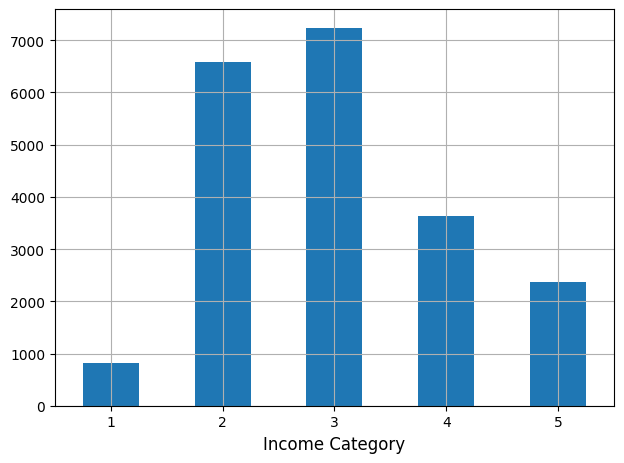

In [29]:
dataset['income_category'].value_counts().sort_index().plot.bar(rot = 0, grid=True)
plt.xlabel('Income Category')
save_fig('figure_2')
plt.show()

In [30]:
splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)
stratified_split = []

for train_index, test_index in splitter.split(dataset, dataset['income_category']):
    stratified_train_set_n = dataset.iloc[train_index]
    stratified_test_set_n = dataset.iloc[test_index]
    stratified_split.append([stratified_train_set_n, stratified_test_set_n])


In [31]:
strat_train_set, strat_test_set = stratified_split[0]

In [32]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_category
6724,-122.11,37.98,11.0,4371.0,679.0,1790.0,660.0,6.1350,297300.0,NEAR BAY,5
4480,-117.10,33.17,12.0,2465.0,412.0,1226.0,428.0,5.4819,183800.0,<1H OCEAN,4
6108,-118.06,34.71,14.0,2606.0,514.0,1228.0,512.0,2.5764,150000.0,INLAND,2
16099,-122.28,38.31,52.0,58.0,18.0,48.0,22.0,1.7600,166700.0,NEAR BAY,2
8664,-118.51,34.22,36.0,1493.0,285.0,766.0,272.0,4.8646,213200.0,<1H OCEAN,4
...,...,...,...,...,...,...,...,...,...,...,...
13507,-118.09,33.90,37.0,1147.0,258.0,742.0,242.0,4.0461,153500.0,<1H OCEAN,3
14450,-122.22,38.11,43.0,1939.0,353.0,968.0,392.0,3.1848,112700.0,NEAR BAY,3
15432,-122.22,37.79,44.0,1487.0,314.0,961.0,272.0,3.5156,109500.0,NEAR BAY,3
4642,-119.87,36.79,7.0,1932.0,419.0,1014.0,389.0,3.0938,76700.0,INLAND,3


In [33]:
strat_train_set, strat_test_set = train_test_split(dataset, test_size = 0.3, stratify = dataset['income_category'],random_state = 42)

In [34]:
strat_test_set['income_category'].value_counts() / len(strat_test_set)

income_category
3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: count, dtype: float64

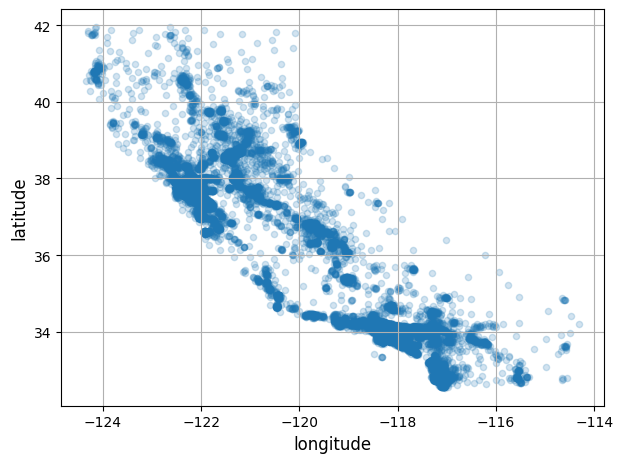

In [35]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True, alpha=0.2)
save_fig('')
plt.show()

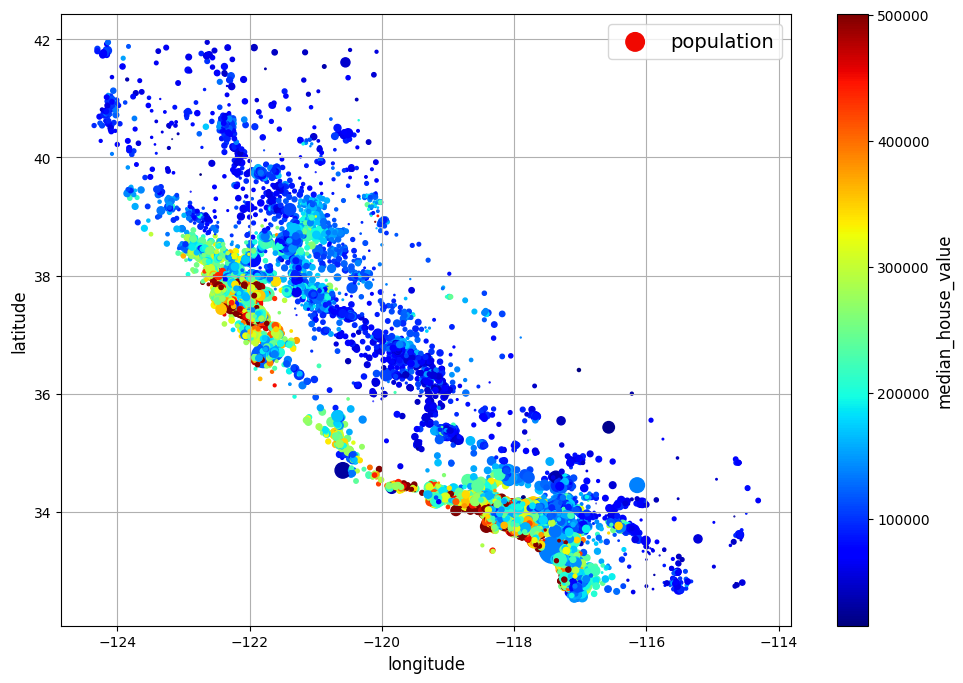

In [36]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
             s =dataset['population']/100, label = 'population',
             c = 'median_house_value', cmap = 'jet', colorbar= True, figsize = (10,7))
save_fig('mapa de calor - population')
plt.show()

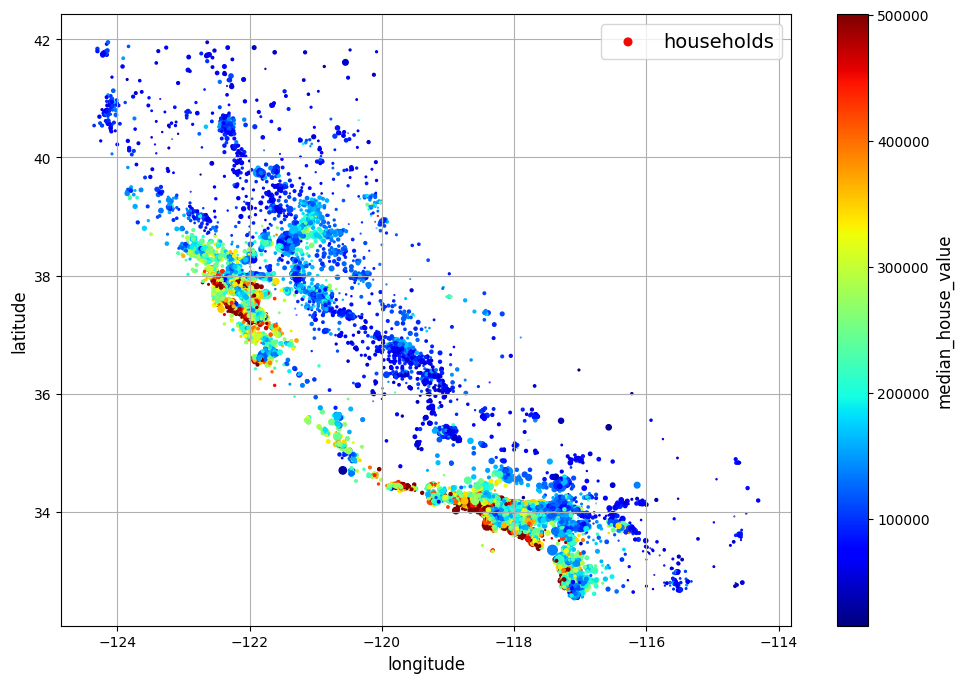

In [37]:
dataset.plot(kind = 'scatter', x = 'longitude', y = 'latitude', grid = True,
             s =dataset['households']/100, label = 'households',
             c = 'median_house_value', cmap = 'jet', colorbar= True, figsize = (10,7))
save_fig('mapa de calor - households')
plt.show()